# Lab 3 -- Correlation

Having explored the realm of frequency analysis tbrough the Fast Fourier Transform (FFT), where we dissected signals into their constituent frequencies, we now shift our focus to another powerful tool in signal processing: **autocorrelation (ACF)**. While FFT helps us understand the frequency components of a signal, autocorrelation offers a different perspective by measuring how a signal correlates with itself over varying time lags. This self-referential approach doesn't just complement our frequency-based insights but opens up new avenues for analyzing signal properties such as periodicity, signal similarity over time, and identifying repeating patterns. Autocorrelation, therefore, stands as a crucial technique, especially when the frequency content alone isn't sufficient to capture the full story of a signal's behavior.

## Example 1: Autocorrelation of Pure Tone

We now consider the autocorrelation of a pure tone signal:
$$
s(t) = \cos(2\pi \cdot f_0 \cdot t)
$$

Text(0, 0.5, 'Correlation')

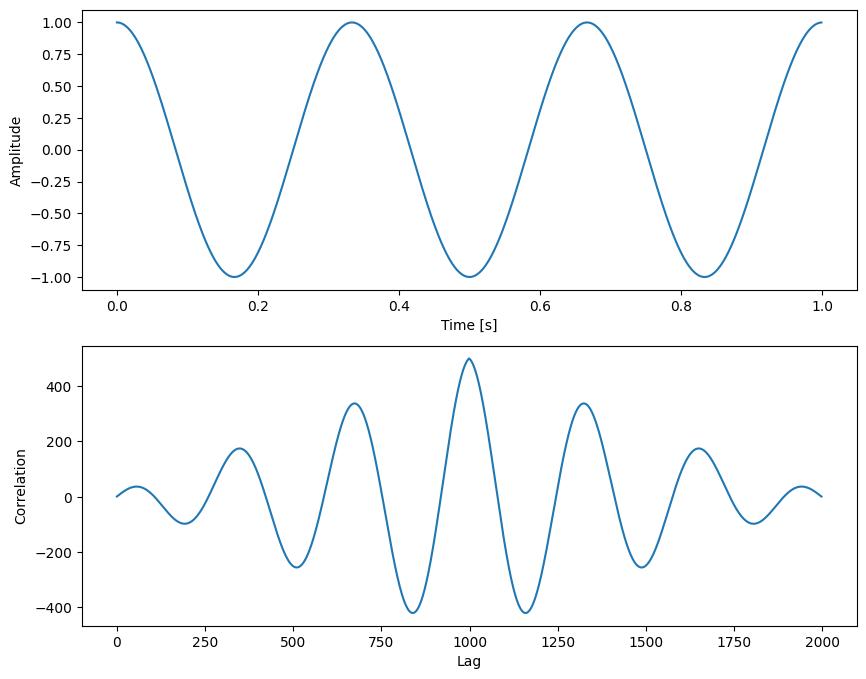

In [7]:
import numpy as np
from scipy.signal import correlate
from matplotlib import pyplot as plt

fs = 1000
t = np.arange(0, 1, 1/fs)
f0 = 3

s_t = np.cos(2*np.pi*f0*t)

corr = correlate(s_t, s_t, mode='full')
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(t, s_t)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(corr)
plt.xlabel("Lag")
plt.ylabel("Correlation")

The graph of above correlation is symmetric, which means, again, only half of the information is useful. In common practice, we tend to normalize the highest peak to 1. So a complete version of calculating autocorrelation is as below:

Text(0, 0.5, 'Correlation')

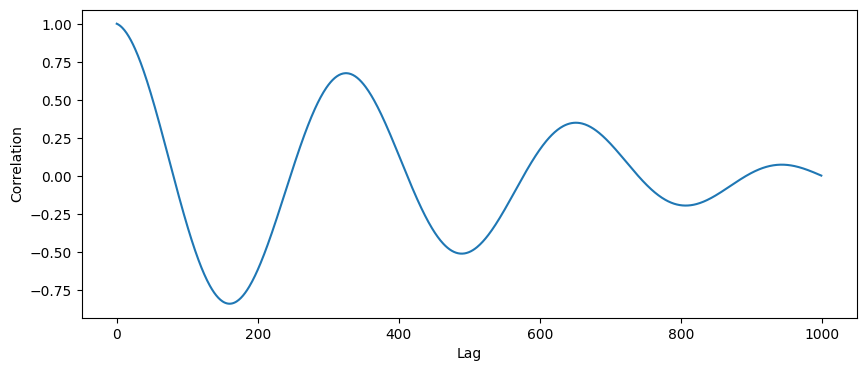

In [8]:
corr = correlate(s_t, s_t, mode='full')
n = len(corr)
corr = corr[n//2:]
# normalize
corr /= corr[0]
plt.figure(figsize=(10, 4))
plt.plot(corr)
plt.xlabel("Lag")
plt.ylabel("Correlation")

We can observe many peaks on the graph with various lags. Now we need to figure out two things:
- What is the meaning of lag?
- What is the meaning of these peaks?

## Example 2: An illustration of the ACF process

Here we illustrate the process of computing ACF. The code below is not required for you. You can execute and watch the generated video.

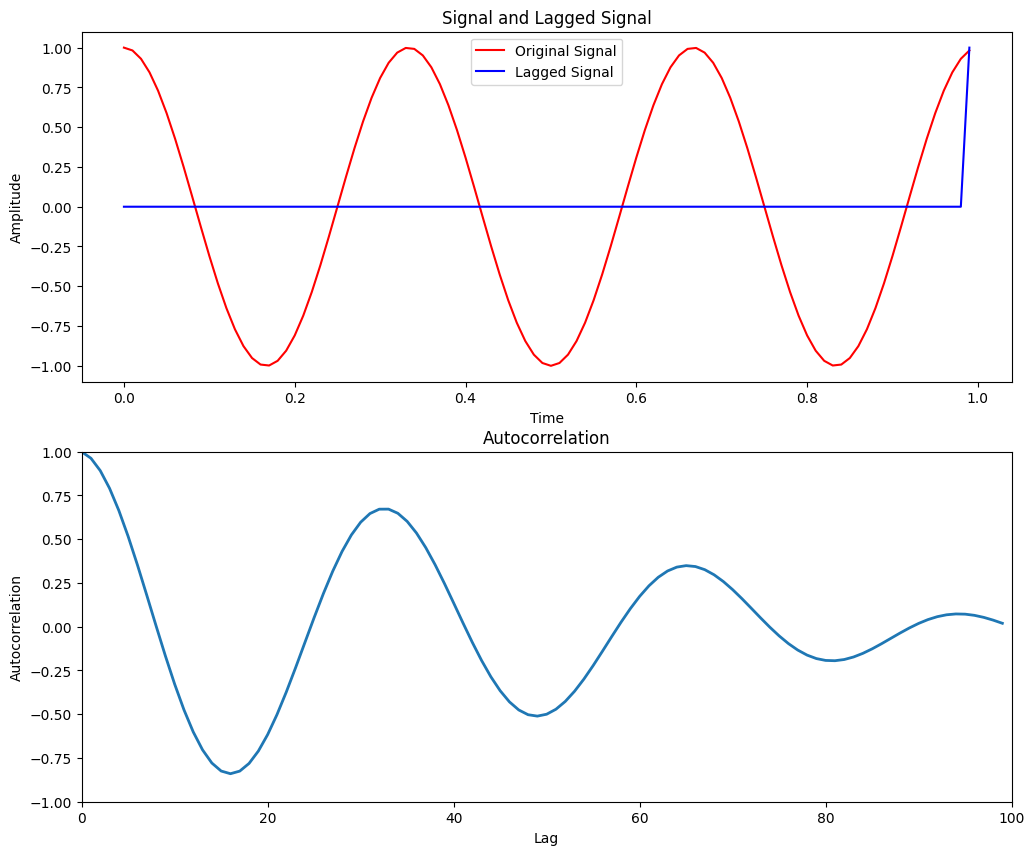

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML    

# Generate sample time series data
fs = 100
t = np.arange(0, 1, 1/fs)
f0 = 3
s_t = np.cos(2*np.pi*f0*t) 

# Autocorrelation function 
def autocorrelation(x):
    result = correlate(x, x, mode='full')
    result /= np.max(result)
    result = result[result.size // 2:]
    return result

def signal_roll(x, lag, pad_value=0):
    result = np.zeros_like(x)
    if lag > 0:
        result[:lag] = pad_value
        result[lag:] = x[:-lag]
    elif lag < 0:
        result[lag:] = pad_value
        result[:lag] = x[-lag:]
    else:
        result = x
    return result

acf = autocorrelation(s_t)

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plotting the original signal
ax1.plot(t, s_t, label='Original Signal', color='red')
line_lagged, = ax1.plot(t, s_t, label='Lagged Signal', color='blue')
ax1.set_title('Signal and Lagged Signal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Placeholder for the autocorrelation plot
ax2.set_title('Autocorrelation')
ax2.set_xlim(0, len(t))
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.set_ylim(-1, 1)
line_autocorr, = ax2.plot([], [], lw=2)
line_autocorrs = []

# Initialize animation
def init():
    line_lagged.set_data([], [])
    line_autocorr.set_data([], [])
    return line_lagged, line_autocorr

# Update function for the animation
def update(lag):
    # Update the lagged signal
    lagged_signal = signal_roll(s_t, lag)
    line_lagged.set_data(t, lagged_signal)
    
    # Calculate and update the autocorrelation plot
    autocorr = acf[lag]
    
    line_autocorrs.append(autocorr)
    lags = np.arange(len(line_autocorrs))
    line_autocorr.set_data(lags, line_autocorrs)
    
    return line_lagged, line_autocorr

max_lag = len(t)   # Max lag is half the signal length to avoid too much empty space
ani = FuncAnimation(fig, update, frames=range(max_lag), init_func=init, blit=True, repeat=False)

# # Display the animation
HTML(ani.to_html5_video())

As can be seen from the animation, lag means the step the signal moves. When the signal moves to the positive direction, 0 will be padding in the empty place. And multiplication will be exercised between the "delayed" signal and original signal. Therefore, ACF will observe the largest value at lag=0. At the same time, we will observe peaks at each period point. Intuitively, correlation is an approach for measuring the **similarity** of two signals. Auto-correlation can be viewed as the special case of correlation, i.e. comparing the shifted version with itself. When there is no shift (lag=0), similarity reaches the maximum value. When lag equals to the periodicity, at least one part of the signal is perfectly matched, thus reaching the peak.

Different from FFT, ACF can only acquire one frequency, namely low frequency. Low frequency indicates the overall trend and periodicty of the signal. The algorithm is both computationally faster and significantly more accurate compared to the FFT, since the resolution is not limited by the number of samples used.

## Example 3: Extract the periodicity from ACF

(array([20, 40, 60, 79]), array([0.2 , 0.4 , 0.6 , 0.79]))

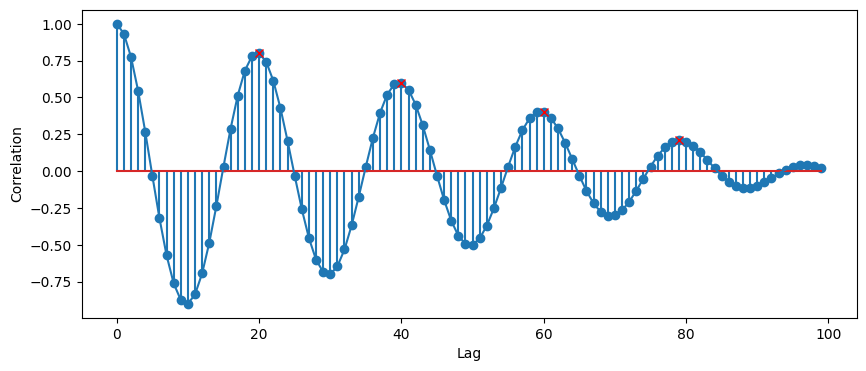

In [10]:
import numpy as np
from scipy.signal import correlate, find_peaks
from matplotlib import pyplot as plt

# Autocorrelation function 
def autocorrelation(x):
    result = correlate(x, x, mode='full')
    result /= np.max(result)
    result = result[result.size // 2:]
    return result

# Generate sample time series data
fs = 100
t = np.arange(0, 1, 1/fs)
f0 = 5
s_t = np.cos(2*np.pi*f0*t) 

acf = autocorrelation(s_t)
x, _ = find_peaks(acf, prominence=0.1)
plt.figure(figsize=(10, 4))
plt.stem(acf)
plt.plot(acf)
plt.plot(x, acf[x], "x", color='red')
plt.xlabel("Lag")
plt.ylabel("Correlation")
x, t[x]

See, peaks will be observed when it reaches its periodicty. As usual, we can use the **first peak** as the result, which is 0.2s, corresponding to frequency of 5Hz.

## Example 4: Adding Windows

ACF is a time-domain approach, which means it does not transform it to the frequency domain and acquire frequency directly from the time domain. If we want to get more information with the temporal change of frequency, we can use a **sliding window** along the temporal domain, especially when processing a long time series.

Sampling frequency: 20 Hz


Text(0, 0.5, 'Amplitude')

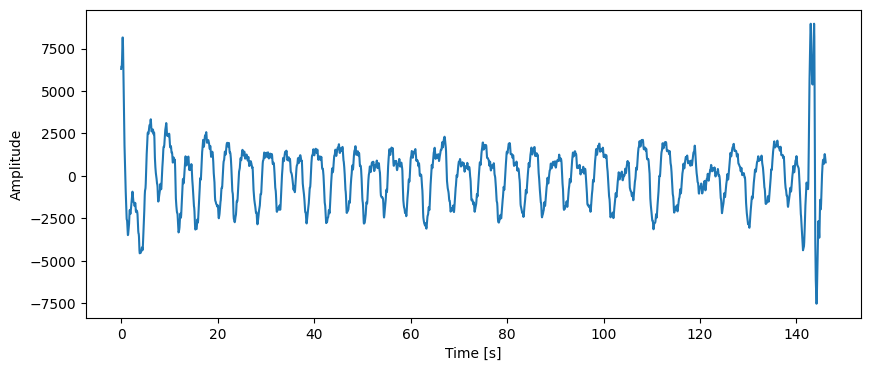

In [11]:
import pickle
from matplotlib import pyplot as plt
br_p = "./example_data/br_0007800f30e4_2023-09-06_15-32-13.pkl"
with open(br_p, "rb") as f:
    br = pickle.load(f)
br_v, fs = br["values"], br["fs"]
print(f"Sampling frequency: {fs} Hz")
br_ts = np.arange(0, len(br_v)/fs, 1/fs)
plt.figure(figsize=(10, 4))
plt.plot(br_ts, br_v)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Breathing Rate [bpm]')

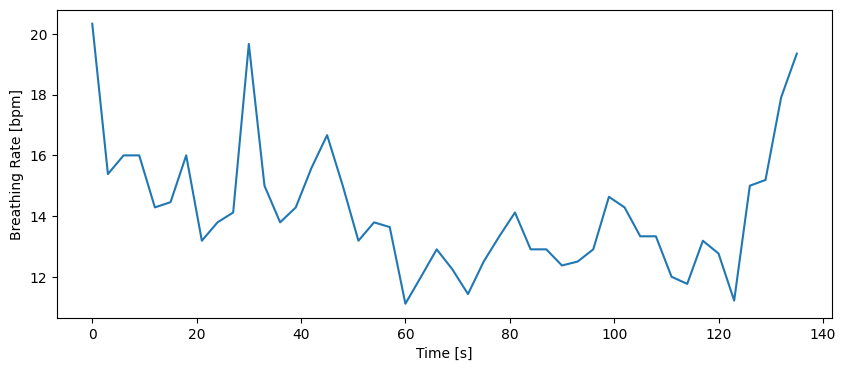

In [12]:
window_t = 10 # seconds
window_step = 3 # seconds
window_n = int(window_t * fs)

brs = []
timestamps = []
for i in range(0, len(br_v) - window_n, int(window_step * fs)):
    # print(f"Processing window {i} to {i+window_n}")
    window = br_v[i:i+window_n]
    acf = autocorrelation(window)
    try:
        x, _ = find_peaks(acf, prominence=0.05)
        br = fs / x[0] * 60 # convert to bpm
    except IndexError:
        plt.figure(figsize=(10, 4))
        plt.subplot(2, 1, 1)
        plt.plot(acf)
        plt.subplot(2, 1, 2)
        plt.plot(window)
    t_s = i / fs
    brs.append(br)
    timestamps.append(t_s)
plt.figure(figsize=(10, 4))
plt.plot(timestamps, brs)
plt.xlabel("Time [s]")
plt.ylabel("Breathing Rate [bpm]")


As shown above, we use a window of 10s and time step of 3s to calculate the breathing rate over time, namely $b(t)$. It will result in the time resolution of 3s in $b(t)$. The frequency resolution is determined by the window length, i.e. $1/T$, where $T$ is the window length.

In a nutshell, we introduce ACF in this lab. You are required to know the physical meaning of ACF, get an intuitive understanding of the process of ACF and most importantly, be capable of calculating ACF and periodicity using code.

## Programming Task

Please refer to `task_3.pdf` for more details.

After implementing the tasks, **please run `python check.py --uid <YOUR_UID>` before submitting.** This script performs automated tests on the examples provided in the docstrings. Failing these tests indicates potential critical issues in your code. Strive to resolve these problems. After that, it will create a zip file named after your `uid`. Make sure you enter the right `uid`. 

It's important to avoid changing the names of any files, including both the zip file and the program files contained within. Altering file names can lead to grading errors. Ensure that all file names remain as they are to facilitate accurate assessment of your work.

Your submission to **Moodle** should consist solely of the **generated `*.zip` file**. It is your responsibility to double check whether your submitted zip file includes your latest work. 